# Expectation-Maximization

In this assignment we will be using the Expectation Maximization method to estimate the parameters of the same three coin experiment as in the theoretical part. We will examine the behavior of the algorithm for various combinations of parameters.

## Description of the Experiment

The following procedure generates the data for the three coin experiment.

The parameters are:

- $\lambda$ := The probability of heads on the hidden coin H.

- $p_1$ := The probability of heads on coin A.

- $p_2$ := The probability of heads on coin B.

Each of the $N$ samples is collected the following way:

- The secret coin (H) is tossed.

- If the result is heads, coin A is tossed $M$ times and the results are recorded.

- If the result is tails, coin B is tossed $M$ times and the results are recorded.

**Heads are recorded as 1.** 

**Tails are recorded as 0.**

The data is returned as an **$N \times M$** matrix, where each of the $N$ rows correspond to the trials and contains the results of the corresponding sample (generated either by coin A or by coin B).

## Description of Provided Functions

Three functions are provided for your convenience:

*  **`utils.generateData(lambda,p1,p2,N,M)`:** Performs the experiment $N$ times with coin parameters specified as argument and returns the results in a $N \times M$ matrix.


* **`utils.unknownData()`** Returns a dataset of size $N \times M$ where generation parameters are unknown.


*  **`utils.plot(data,distribution)`:** Plot a histogram of the number of heads per trial along with the probability distribution. This function will be used to visualize the progress of the EM algorithm at every iteration.

An example of use of these two functions is given below:

[[0 1 1 0 1]
 [1 0 0 0 0]
 [1 1 1 1 1]
 [1 0 1 0 0]
 [0 1 1 1 0]
 [0 0 0 1 0]
 [0 1 1 1 1]
 [0 0 0 1 1]
 [1 1 0 1 0]
 [1 0 1 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [1 1 1 1 1]
 [1 0 1 1 0]]


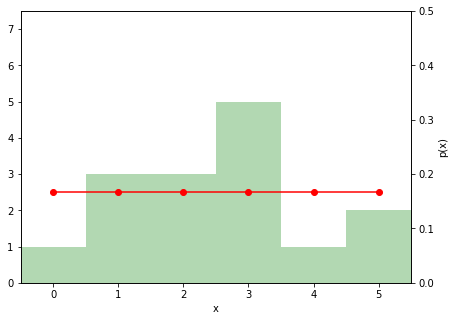

In [2]:
%matplotlib inline
import numpy,utils

# Print the data matrix as a result of the three coins experiment with parameter 0.5, 0.8 and 0.2.
data = utils.generateData(0.5,0.8,0.2,15,5)
print(data)

# Print the data histogram along with a uniform probability distribution.
utils.plot(data,numpy.ones([data.shape[1]+1])/(data.shape[1]+1))

## Calculate the Log-Likelihood (15 P)

Implement a function which calculates the log likelihood for a given dataset and parameters. The log-likelihood is given by:
$$
LL = \frac1N \sum_{i=1}^N \log \!\! \sum_{z \in \{\mathrm{heads},\mathrm{tails}\}} \!\! P(X=x_i, Z=z \mid \theta)\\
   = \frac1N \sum_{i=1}^N \log \left[ \lambda \cdot p_1^{h(x_i)} \cdot (1-p_1)^{t(x_i)} + (1-\lambda) \cdot p_2^{h(x_i)} \cdot (1-p_2)^{t(x_i)} \right]
$$
where $h(x_i)$ and $t(x_i)$ denote the number of heads and tails in sample $i$, respectively. Note that we take the averaged log-likelihood over all trials, hence the multiplicative term $\frac1N$ in front.

In [33]:
import numpy as np
import collections
import scipy.special

# http://karlrosaen.com/ml/notebooks/em-coin-flips/
def loglikelihood(data,lam,p1,p2):
    n_tosses = data.shape[0] # matrix height
    m_tosses = data.shape[1] # each coin tossed M times
    
    n_heads = np.sum(data, axis=1)
    n_tails = n_tosses - n_heads
    
    #probs = numpy.zeros(n_tosses, dtype=numpy.float) # for keeping the data during the loop
    log_l = numpy.log(scipy.special.binom(m_tosses, n_heads)*(lam*pow(p1,n_heads)*pow(1-p1,n_tails) + (1-lam)*pow(p2,n_heads)*pow(1-p2,n_tails)))
    '''
    for i in range(0, n_tosses):
        counter = collections.Counter(data[i,:]) # to track the number of  ones ans zeros
        n_heads = counter[1]
        n_tails = counter[0]
        #LL = numpy.log(scipy.special.binom(M, heads_nr)*(lam*pow(p1,heads_nr)*pow(1-p1,tails_nr) + (1-lam)*pow(p2,heads_nr)*pow(1-p2,tails_nr)))
        probs[i] = np.log(lam*(p1**n_heads)*((1 - p1)**n_tails) + (1 - lam)*(p2**n_heads)*((1 - p2)**n_tails))
        #print(probs[i])
    '''
    
    log_l = np.sum(log_l) / n_tosses
    print(log_l)    
    return log_l
    #return sum(LL)/n_tosses
        
loglikelihood(data, 0.5, 0.8,0.2)

-5.8948818028922165


-5.8948818028922165

## Implementing and Running the EM Algorithm (35 P)

Implement a function which iteratively determines the values of $\lambda$, $p_1$ and $p_2$. The function starts with some initial estimates for the parameters and returns the results of the method for those parameters.

In each iteration, the following update rules are used for the parameters:

$$\lambda^{new} = \frac{E(\#heads(coin\_H))}{\#throws(coin\_H)} = \frac{1}{N}\sum_{i=1}^{N}\frac{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)}}{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)} + (1-\lambda)p_2^{h(x_i)}(1-p_2)^{t(x_i)}}$$

$$p_1^{new} = \frac{E(\#heads(coin\_A))}{E(\#throws(coin\_A))} = \frac{\sum_{i=1}^{N}R_1(i)h(x_i)}{M \sum_{i=1}^{N}R_1(i)}$$

$$p_2^{new} = \frac{E(\#heads(coin\_B))}{E(\#throws(coin\_B))} = \frac{\sum_{i=1}^{N}R_2(i)h(x_i)}{M \sum_{i=1}^{N}R_2(i)}$$

where $h(x_i)$ and $t(x_i)$ denote the number of heads and tails in sample i, respectively, and

$$R_1(i) = \frac{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)}}{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)} + (1-\lambda)p_2^{h(x_i)}(1-p_2)^{t(x_i)}}$$

$$R_2(i) = \frac{(1-\lambda) p_2^{h(x_i)}(1-p_2)^{t(x_i)}}{\lambda p_1^{h(x_i)}(1-p_1)^{t(x_i)} + (1-\lambda)p_2^{h(x_i)}(1-p_2)^{t(x_i)}}$$


**TODO:**

* **Implement the EM learning procedure.**
* **Use as stopping criterion the improvement of log-likelihood between two iterations to be smaller than $0.001$.**
* **Run the EM procedure on the data returned by function `utils.unknownData()`. Use as an initial solution for your model the parameters $\lambda = 0.5$, $p_1 = 0.25$, $p_2 = 0.75$ **.
* **At each iteration of the EM procedure, print the log-likelihood and the value of your model parameters, and plot the learned probability distribution using the function utils.plot().**

In [6]:
import utils
%matplotlib inline

# --------------------
# REPLACE BY YOUR CODE
import solution; solution.EM()
# --------------------


# -------------------------------------------
# Template for your code
# -------------------------------------------
#TODO: Initialize the model
lam = None
p1  = None
p2  = None

criterion = None # (to be set to True)

# Iterate until the stopping criterion is satisfied
while (criterion == False):

    #TODO:
    # - Perform one step of EM
    # - Print the log-likelihood and the model parameters
    # - Plot data histogram and the learned probability distribution
    # - Determine if stopping criterion is satisfied

    print('it:%2d  lambda: %.2f  p1: %.2f  p2: %.2f  log-likelihood: %.3f'%(it, lam, p1, p2, loglikelihood))
# -------------------------------------------

ModuleNotFoundError: No module named 'solution'